In [2]:
import os
import gc
import math
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
sns.set(style="darkgrid")
%config IPCompleter.greedy = True
%config Completer.use_jedi = False

In [3]:
non_reoccuring_number = 100
minute_interval = 1
second_interval = 15

In [4]:
peaks = pd.read_csv(f"../../data/peaks/peaks.csv")
seasonal = pd.read_csv(f"../../data/seasonal.csv")

In [5]:
corrected_1 = pd.read_csv(f"../../data/corrected_m1/corrected_data_{minute_interval}_{non_reoccuring_number}.csv")
corrected_1['date'] = pd.to_datetime(corrected_1['date'])
corrected_1['ndt'] = pd.to_datetime(corrected_1.date) + corrected_1.hours.astype('timedelta64[h]') + corrected_1.minutes.astype('timedelta64[m]')
corrected_1.drop(columns=['combined', 'hours', 'minutes', 'date'], inplace=True)

In [6]:
data = pd.read_csv(f"../../data/raw_{minute_interval}m_{second_interval}s.csv", index_col=0)
data['ndt'] = pd.to_datetime(data['ndt'])

/opt/conda/envs/bp/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [7]:
# Removing first and last days from the data
data = data[data.ndt.dt.date != datetime.date(2019,6,12)]
data = data[data.ndt.dt.date != datetime.date(2019,8,6)]
data = data[~((data.ndt.dt.date == datetime.date(2019,6,13)) & (data.ndt.dt.hour <= 6))]
data = data[~((data.ndt.dt.date == datetime.date(2019,8,5)) & (data.ndt.dt.hour >= 6))]

In [8]:
data_counts = data.groupby(['hash']).count()
data_counts.columns = ['count']
data_counts = data_counts[data_counts['count'] > non_reoccuring_number]

In [9]:
data = data[data['hash'].isin(data_counts.index.values)]

In [10]:
data_grp = data.groupby(['hash', 'ndt']).size()

In [11]:
del data

In [15]:
data_grp = pd.DataFrame(data_grp)
data_grp.columns = ['count']

## Data correction with a smaller window

In [17]:
missing_values = list()
total_length = len(seasonal['hash'])+len(peaks['hash'])

for i, series_id in enumerate((*seasonal['hash'], *peaks['hash'])):
    if (series_id not in data_grp.index):
        continue
    
    # Data is already in time floor format
    ls_series_data = data_grp.loc[series_id].sort_index()
    ls_start = ls_series_data.index[0]
    ls_end = ls_series_data.index[-1]

    if(not ls_start.date() < pd.Timestamp('2019-07-1 06:30:00')):
        continue
    if(not ls_end.date() > pd.Timestamp('2019-07-2 06:30:00')):
        continue
    
    
    # resample, data is already aligned with interval but may contain gaps
    previous_day = ls_series_data.loc['2019-6-30 06:00:00':'2019-7-1 07:00:00']
    following_day = ls_series_data.loc['2019-7-2 06:00:00':'2019-7-3 07:00:00']
    if (second_interval != 0):
        previous_day = previous_day.resample(f'{second_interval}S').sum().fillna(0)
        following_day = following_day.resample(f'{second_interval}S').sum().fillna(0)
    else:
        previous_day = previous_day.resample(f'{minute_interval}T').sum().fillna(0)
        following_day = following_day.resample(f'{minute_interval}T').sum().fillna(0)
    
    print(f"\r{i+1}/{total_length}", end="")
    combined_dates = previous_day.append(following_day)
    mean_day = combined_dates.groupby([combined_dates.index.hour, combined_dates.index.minute, combined_dates.index.second]).mean() 
    if (second_interval != 0):
        # Using seconds
        for date in pd.date_range('2019-7-1 06:30:00', '2019-7-2 06:30:00', freq=f'{second_interval}s'):
            dt_val = 0
            if (date.hour, date.minute, date.second) in mean_day.index:
                dt_val = mean_day.loc[date.hour, date.minute, date.second][0]
            # Will need to resample but will save memory
            if(dt_val == 0):
                continue
            if (series_id, date) in data_grp.index:
                data_grp.loc[series_id, date] = dt_val
            else:
                missing_values.append({'hash':series_id, 'ndt':date.to_datetime64(), 'count': dt_val})
    else:
        # Using minutes
        for date in pd.date_range('2019-7-1 06:00:00', '2019-7-2 07:00:00', freq=f'{minute_interval}T'):
            dt_val = 0
            if (date.hour, date.minute, date.second) in mean_day.index:
                dt_val = mean_day.loc[date.hour, date.minute, date.second][0]
            # Will need to resample but will save memory
            if(dt_val == 0):
                continue
            if (series_id, date) in data_grp.index:
                data_grp.loc[series_id, date] = dt_val
            else:
                missing_values.append({'hash':series_id, 'ndt':date.to_datetime64(), 'count': dt_val})

12573/13034

In [18]:
data_grp = data_grp.reset_index().append(pd.DataFrame(missing_values))
del missing_values
data_grp['ndt'] = pd.to_datetime(data_grp['ndt'])
data_grp = data_grp.groupby(['hash', 'ndt']).sum()

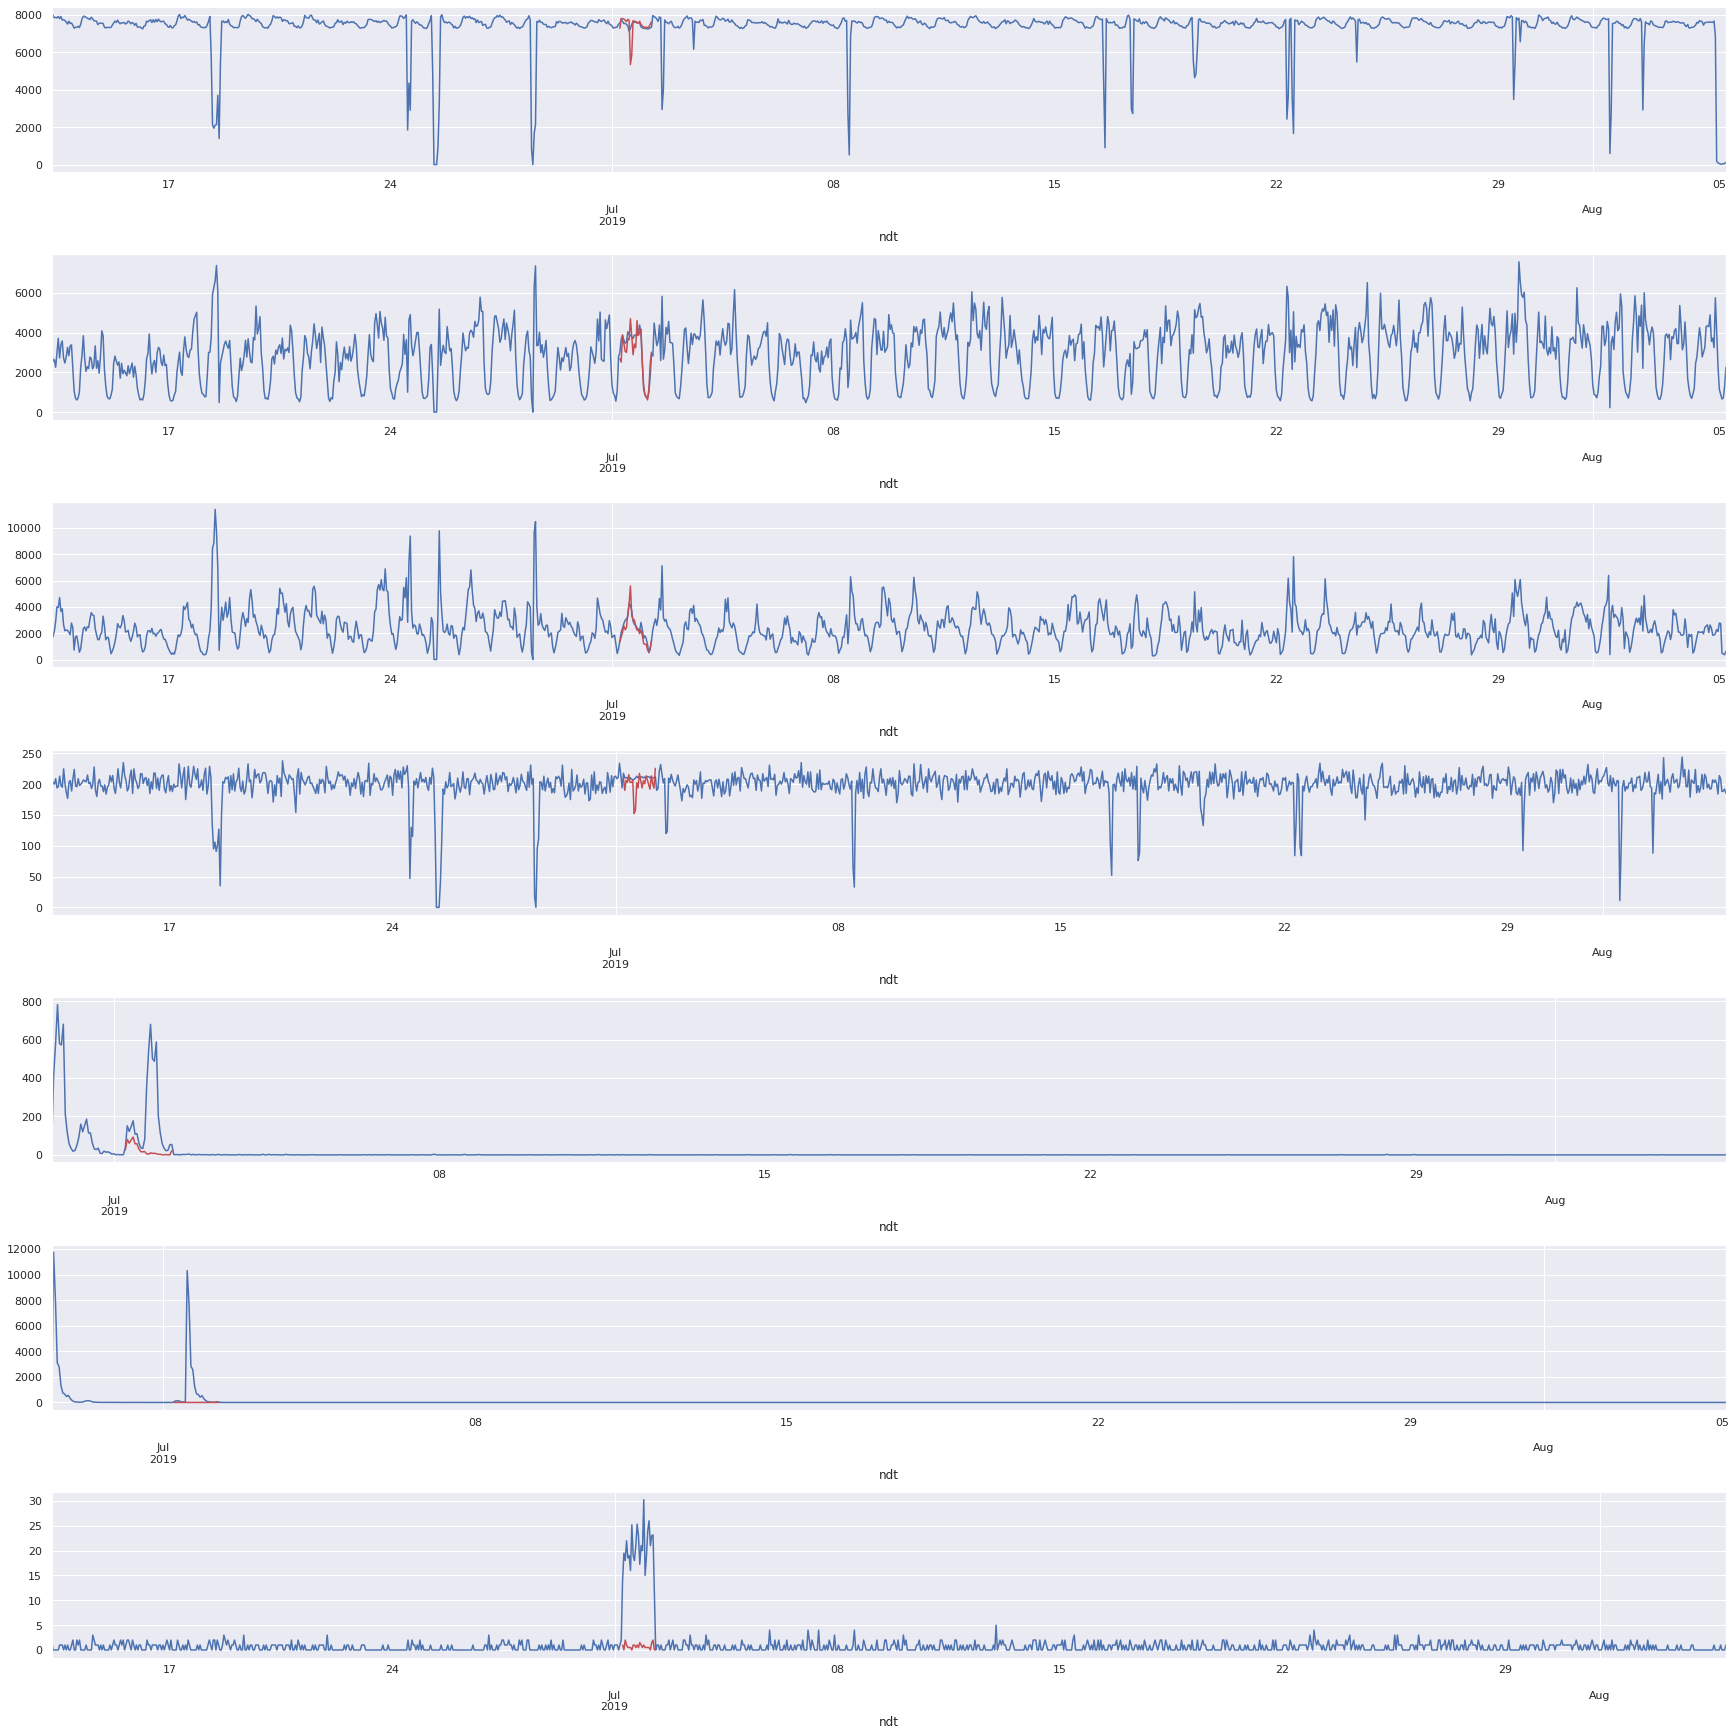

In [20]:
fig, ax = plt.subplots(7,1, constrained_layout=True)
fig.set_size_inches(24, 24)

corrected_1[corrected_1['hash'] == '60940bbf1a3b82169641ba159686a6ca'].set_index('ndt').resample(f'1h').sum()['count'].plot(ax=ax[0])
data_grp.loc['60940bbf1a3b82169641ba159686a6ca'].resample(f'1h').sum().loc['2019-7-1 06:00:00':'2019-7-2 06:30:00']['count'].plot(ax=ax[0], color='r')

corrected_1[corrected_1['hash'] == 'd03517f419b520bed290a38e43f578d5'].set_index('ndt').resample(f'1h').sum()['count'].plot(ax=ax[1])
data_grp.loc['d03517f419b520bed290a38e43f578d5'].resample(f'1h').sum().loc['2019-7-1 06:00:00':'2019-7-2 06:30:00']['count'].plot(ax=ax[1], color='r')

corrected_1[corrected_1['hash'] == '4e395735b02fc10b9ffc1ca9c28c984f'].set_index('ndt').resample(f'1h').sum()['count'].plot(ax=ax[2])
data_grp.loc['4e395735b02fc10b9ffc1ca9c28c984f'].resample(f'1h').sum().loc['2019-7-1 06:00:00':'2019-7-2 06:30:00']['count'].plot(ax=ax[2], color='r')

corrected_1[corrected_1['hash'] == '8d8b99524b2319835b6caec2dd369b12'].set_index('ndt').resample(f'1h').sum()['count'].plot(ax=ax[3])
data_grp.loc['8d8b99524b2319835b6caec2dd369b12'].resample(f'1h').sum().loc['2019-7-1 06:00:00':'2019-7-2 06:30:00']['count'].plot(ax=ax[3], color='r')

corrected_1[corrected_1['hash'] == '23e510e77a556241ec01dad0f70b4c92'].set_index('ndt').resample(f'1h').sum()['count'].plot(ax=ax[4])
data_grp.loc['23e510e77a556241ec01dad0f70b4c92'].resample(f'1h').sum().loc['2019-7-1 06:00:00':'2019-7-2 06:30:00']['count'].plot(ax=ax[4], color='r')

corrected_1[corrected_1['hash'] == '9cf43a76bac1a739dcde9735f515bcfa'].set_index('ndt').resample(f'1h').sum()['count'].plot(ax=ax[5])
data_grp.loc['9cf43a76bac1a739dcde9735f515bcfa'].resample(f'1h').sum().loc['2019-7-1 06:00:00':'2019-7-2 06:30:00']['count'].plot(ax=ax[5], color='r')

#corrected_1[corrected_1['hash'] == 'a22a87bd6b37676a79ebad706aa1f015'].set_index('ndt').resample(f'1h').sum()['count'].plot(ax=ax[6])
#data_grp.loc['a22a87bd6b37676a79ebad706aa1f015'].resample(f'1h').sum().loc['2019-7-1 06:00:00':'2019-7-2 06:30:00']['count'].plot(ax=ax[6], color='r')

corrected_1[corrected_1['hash'] == '06ffcd3c0a4c198fe8af431de6ea651f'].set_index('ndt').resample(f'1h').sum()['count'].plot(ax=ax[6])
data_grp.loc['06ffcd3c0a4c198fe8af431de6ea651f'].resample(f'1h').sum().loc['2019-7-1 06:00:00':'2019-7-2 06:30:00']['count'].plot(ax=ax[6], color='r')

In [21]:
#data_grp.to_csv(f"../../data/corrected_m2/corrected_data_2_{minute_interval}m_{second_interval}s.csv")

In [5]:
data_grp = pd.read_csv(f"../../data/corrected_m2/corrected_data_2_{minute_interval}m_{second_interval}s.csv", index_col=[0,1], parse_dates=True)

In [38]:
import matplotlib
import matplotlib.dates as mdates
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
%matplotlib inline

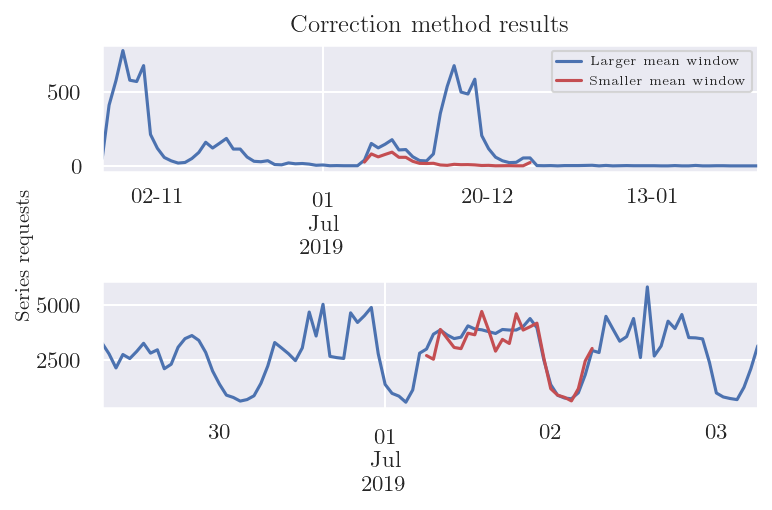

In [75]:
fig, ax = plt.subplots(2, 1, tight_layout=True, dpi=150)
fig.set_size_inches(w=5.10686, h=3.5)

corrected_1[corrected_1['hash'] == '23e510e77a556241ec01dad0f70b4c92'].set_index('ndt').resample(f'1h').sum()['count'][:4*24].plot(ax=ax[0])
data_grp.loc['23e510e77a556241ec01dad0f70b4c92'].resample(f'1h').sum().loc['2019-7-1 06:00:00':'2019-7-2 06:30:00']['count'].plot(ax=ax[0], color='r')



corrected_1[corrected_1['hash'] == 'd03517f419b520bed290a38e43f578d5'].set_index('ndt').resample(f'1h').sum()['count'][24*16:24*20].plot(ax=ax[1])
data_grp.loc['d03517f419b520bed290a38e43f578d5'].resample(f'1h').sum().loc['2019-7-1 06:00:00':'2019-7-2 06:30:00']['count'].plot(ax=ax[1], color='r')

ax[1].set_xlabel("")
ax[0].set_xlabel("")
#ax[0].xaxis.set_major_formatter(mdates.DateFormatter(""))
ax[0].xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m"))
#ax[0].xaxis.set_minor_locator(mdates.MinuteLocator(interval=60*4))
ax[0].legend(["Larger mean window", "Smaller mean window"], fontsize="xx-small", loc='upper right')
ax[0].set_title("Correction method results")
fig.text(0.001, 0.5, 'Series requests', va='center', rotation='vertical')
fig.savefig('../../plots/text-plots/5-correction-methods.pgf')

## Irregural anomalies with incoming data (individual time series)

In [13]:
rs_data_anomaly = data_grp.reset_index().groupby(['ndt', 'hash']).sum()
#.set_index('ndt').resample('60S').sum().fillna(0)

In [79]:
minute_data = rs_data_anomaly.reset_index().groupby('ndt').sum().resample('60S').sum().fillna(0)

In [101]:
def mean_series(data, start, end):
    timestamp_range = pd.date_range(start, end, freq='60S')
    previous_day_range = timestamp_range - pd.Timedelta(days=1)
    following_day_range = timestamp_range + pd.Timedelta(days=1)
    for timestamp in timestamp_range:
        for series in data.loc[timestamp].iterrows():
            new_value = 0
            past_value = timestamp - pd.Timedelta(days=1)
            future_value = timestamp + pd.Timedelta(days=1)
            mean_cnt = 0
            past_count = 0
            future_count = 0
            if (series[0], past_value) in data_grp.index:
                past_count = data_grp.loc[(series[0], past_value)]['count']
                mean_cnt += 1
            if (series[0], future_value) in data_grp.index:
                future_count = data_grp.loc[(series[0], future_value)]['count']
                mean_cnt += 1
            if (mean_cnt != 0):
                new_value = past_count + future_count / mean_cnt
            #print(data.loc[(timestamp, series[0])]['count'], past_count, future_count, new_value)
            data.loc[(timestamp, series[0])]['count'] = new_value
    return data

<AxesSubplot:xlabel='ndt'>

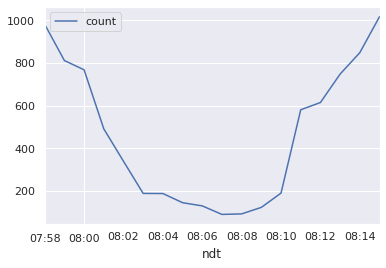

In [85]:
minute_data.loc['2019-07-22 07:58:00':'2019-07-22 8:15:00'].plot()

In [102]:
rs_data_anomaly = mean_series(rs_data_anomaly, '2019-07-22 07:58:00', '2019-07-22 8:15:00')

<AxesSubplot:xlabel='ndt'>

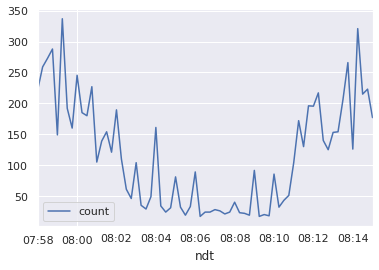

In [103]:
rs_data_anomaly.loc['2019-07-22 07:58:00':'2019-07-22 8:15:00'].groupby('ndt').sum().plot()

<AxesSubplot:xlabel='ndt'>

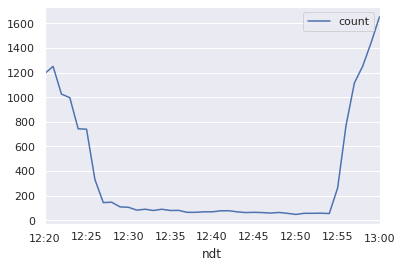

In [113]:
minute_data.loc['2019-07-22 12:20:00':'2019-07-22 13:00:00'].plot()

In [114]:
rs_data_anomaly = mean_series(rs_data_anomaly, '2019-07-22 12:20:00', '2019-07-22 13:00:00')

<AxesSubplot:xlabel='ndt'>

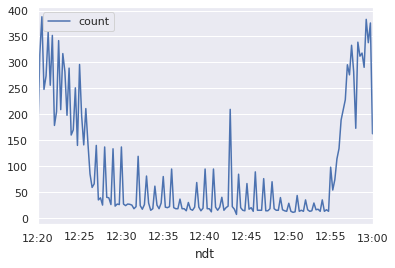

In [115]:
rs_data_anomaly.loc['2019-07-22 12:20:00':'2019-07-22 13:00:00'].groupby('ndt').sum().plot()

The approach used for downtime correction doesn't seem to produce good results on individual series. The problem will be addressed later on component sums.